In [1]:
import pandas as pd


In [ ]:
# Load the required files
vote_sessions = pd.read_csv("../../data/vote_sessions_full.csv", usecols=["id", "data", "aprovacao", "propositionID", "siglaOrgao", "year", "author_type", "num_authors", "theme", "legislatura", "Governo", "Oposição", "GOV."])
authors_pop = pd.read_csv("../../data/author_popularity.csv", usecols=["idVotacao", "popularity"])

# Load the new features
party_popularity = pd.read_csv("../../data/party_popularity_best_window_last_5_sessions.csv", usecols=["id", "party_popularity"])
historical_data = pd.read_csv("../../data/proposition_history_predictions_historical_probability_rule.csv", usecols=["id", "historical_approval_rate"])

# Start with vote_sessions as base
merged_df = vote_sessions.copy()

# Merge with authors_pop (id in vote_sessions matches idVotacao in authors_pop)
merged_df = merged_df.merge(
    authors_pop, left_on="id", right_on="idVotacao", how="left"
)

# Merge with the new enhanced features
merged_df = merged_df.merge(
    party_popularity, left_on="id", right_on="id", how="left"
)

merged_df = merged_df.merge(
    historical_data, left_on="id", right_on="id", how="left"
)

# Remove duplicated columns: "propositionID", "idVotacao"
merged_df = merged_df.drop(columns=["propositionID", "idVotacao"])

# Keep only unique values of the 'id' column
merged_df = merged_df.drop_duplicates(subset=["id"], keep="first")


In [3]:
merged_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 9260 entries, 0 to 41459
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        9260 non-null   object 
 1   data                      9260 non-null   object 
 2   siglaOrgao                9260 non-null   object 
 3   aprovacao                 8914 non-null   float64
 4   year                      9260 non-null   int64  
 5   GOV.                      9260 non-null   int64  
 6   Governo                   9260 non-null   int64  
 7   Oposição                  9260 non-null   int64  
 8   author_type               9260 non-null   object 
 9   num_authors               9260 non-null   int64  
 10  theme                     9252 non-null   object 
 11  legislatura               9260 non-null   int64  
 12  popularity                1990 non-null   float64
 13  party_popularity          8914 non-null   float64
 14  histori

In [4]:
print("Valores únicos da coluna 'GOV.':", merged_df['GOV.'].unique())
print("Valores únicos da coluna 'Governo':", merged_df['Governo'].unique())


Valores únicos da coluna 'GOV.': [ 0  1 -1]
Valores únicos da coluna 'Governo': [ 0  1 -1]


In [5]:
# Calcula a porcentagem de linhas em que 'GOV.' diverge de 'Governo'
total_linhas = len(merged_df)
divergentes_mask = merged_df['GOV.'] != merged_df['Governo']
divergentes = divergentes_mask.sum()
percentual_divergentes = (divergentes / total_linhas) * 100
print(f"Percentual de linhas em que 'GOV.' diverge de 'Governo': {percentual_divergentes:.2f}%")

# Mostra alguns exemplos dessas linhas que divergem
exemplos_divergentes = merged_df.loc[divergentes_mask, ['id', 'GOV.', 'Governo']].head(10)
print("Exemplos de linhas divergentes entre 'GOV.' e 'Governo':")
print(exemplos_divergentes)


Percentual de linhas em que 'GOV.' diverge de 'Governo': 16.59%
Exemplos de linhas divergentes entre 'GOV.' e 'Governo':
             id  GOV.  Governo
75    115155-58     1        0
234  125572-116     1        0
318   145211-10     1        0
351    32147-56     1        0
365    150930-5     1        0
366    151030-5     1        0
436    252929-5     1        0
460   126541-68     1        0
465   140174-83    -1        0
532   109175-70     1        0


In [6]:
def resolve_gov_orientation(row):
    if row['GOV.'] == row['Governo']:
        return row['GOV.']
    else:
        # Se discordam, retorna o valor diferente de zero (1 ou -1)
        if row['GOV.'] != 0:
            return row['GOV.']
        else:
            return row['Governo']

merged_df['gov_orientation'] = merged_df.apply(resolve_gov_orientation, axis=1)


In [7]:
# Convert the 'data' column to datetime
merged_df['data'] = pd.to_datetime(merged_df['data'], errors='coerce')

# Convert the 'aprovacao' column to int
merged_df['aprovacao'] = pd.to_numeric(merged_df['aprovacao'], errors='coerce').astype('Int64')


In [8]:
# Truncate 'num_authors' values at 10, keeping values <=10 as is
merged_df['num_authors_trunc'] = merged_df['num_authors'].apply(lambda x: x if x <= 10 else 10)

# Create a new boolean column to tag propositions with more than 10 authors
merged_df['has_more_than_10_authors'] = merged_df['num_authors'] > 10


In [9]:
# Fill missing values in existing features
merged_df['popularity'] = merged_df['popularity'].fillna(0)

# Fill missing values in new features (removed author_popularity since it's being removed)
merged_df['party_popularity'] = merged_df['party_popularity'].fillna(0)
merged_df['historical_approval_rate'] = merged_df['historical_approval_rate'].fillna(0.5)  # Default to neutral probability


In [10]:
merged_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 9260 entries, 0 to 41459
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   id                        9260 non-null   object        
 1   data                      9260 non-null   datetime64[ns]
 2   siglaOrgao                9260 non-null   object        
 3   aprovacao                 8914 non-null   Int64         
 4   year                      9260 non-null   int64         
 5   GOV.                      9260 non-null   int64         
 6   Governo                   9260 non-null   int64         
 7   Oposição                  9260 non-null   int64         
 8   author_type               9260 non-null   object        
 9   num_authors               9260 non-null   int64         
 10  theme                     9252 non-null   object        
 11  legislatura               9260 non-null   int64         
 12  popularity         

In [11]:
merged_df = merged_df.dropna(subset=['aprovacao'])


In [12]:
# Preencher valores nulos na coluna 'theme' com "Not defined"
merged_df['theme'] = merged_df['theme'].fillna("Not defined")


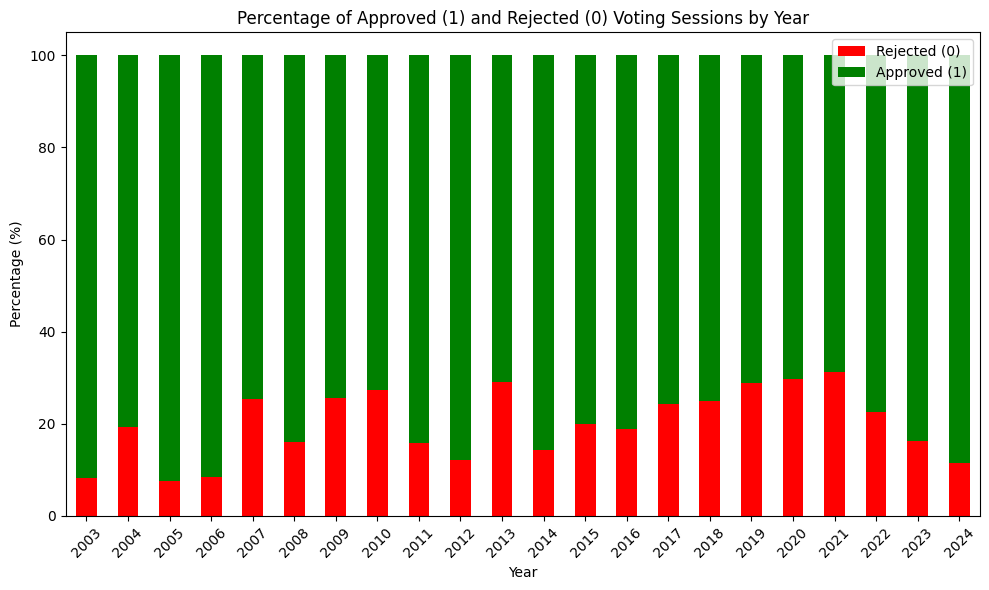

In [13]:
import matplotlib.pyplot as plt

# Ensure 'year' column exists
if 'year' not in merged_df.columns:
    merged_df['year'] = merged_df['data'].dt.year

# Calculate percentage of approved and rejected per year
approval_counts = merged_df.groupby(['year', 'aprovacao']).size().unstack(fill_value=0)
approval_percentages = approval_counts.div(approval_counts.sum(axis=1), axis=0) * 100

# Sort columns to ensure 0 (Rejected) is below 1 (Approved) in the stack
approval_percentages = approval_percentages[[0, 1]] if 0 in approval_percentages.columns and 1 in approval_percentages.columns else approval_percentages

# Plot as stacked bars
fig, ax = plt.subplots(figsize=(10,6))
approval_percentages.plot(
    kind='bar',
    stacked=True,
    ax=ax,
    color={0: 'red', 1: 'green'}
)
ax.set_ylabel('Percentage (%)')
ax.set_xlabel('Year')
ax.set_title('Percentage of Approved (1) and Rejected (0) Voting Sessions by Year')
ax.legend(['Rejected (0)', 'Approved (1)'])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


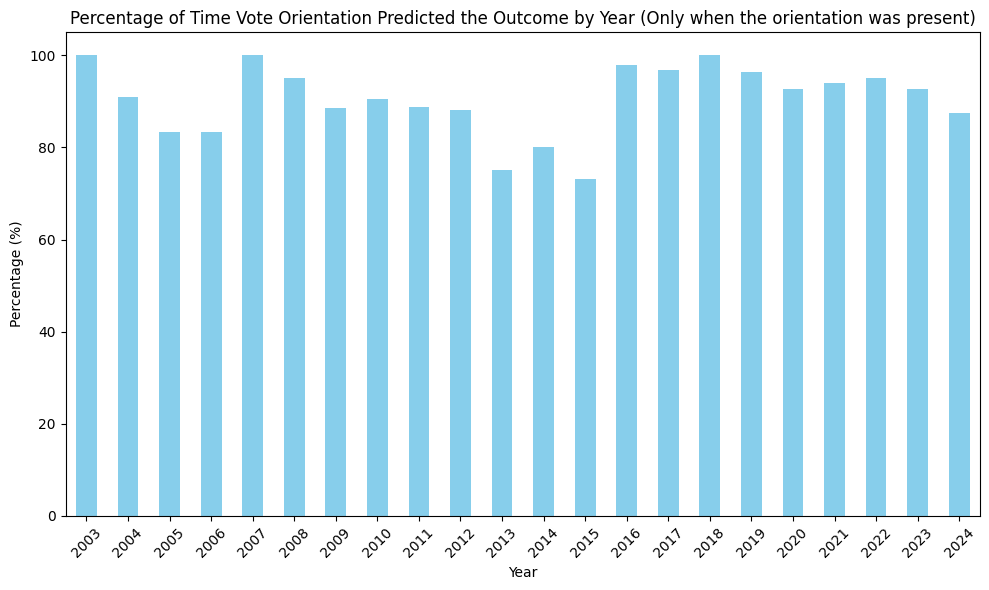

In [14]:
import matplotlib.pyplot as plt

# Consider only rows where gov_orientation is 1 or -1
filtered_df = merged_df[merged_df['gov_orientation'].isin([1, -1])].copy()

# Define a function to determine if the government orientation was "right"
def gov_right(row):
    if row['gov_orientation'] == 1 and row['aprovacao'] == 1:
        return 1
    elif row['gov_orientation'] == -1 and row['aprovacao'] == 0:
        return 1
    else:
        return 0

# Apply the function to each row to create a new column
filtered_df['gov_right'] = filtered_df.apply(gov_right, axis=1)

# Calculate the percentage of time the government orientation was right per year (only for considered rows)
gov_right_perc = filtered_df.groupby('year')['gov_right'].mean() * 100

# Plot the results
fig, ax = plt.subplots(figsize=(10,6))
gov_right_perc.plot(kind='bar', color='skyblue', ax=ax)
ax.set_ylabel('Percentage (%)')
ax.set_xlabel('Year')
ax.set_title('Percentage of Time Vote Orientation Predicted the Outcome by Year (Only when the orientation was present)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [15]:
# Selecionar as features e o target para o novo dataset
# Updated features list - removed unwanted features as requested (including content since content_cluster was removed)
features = [
    'popularity',
    'gov_orientation',
    'num_authors_trunc',
    'has_more_than_10_authors',
    'party_popularity',   # New feature 2
    'historical_approval_rate'  # New feature 3
]
target = 'aprovacao'

# Criar o novo DataFrame apenas com as features e o target
dataset_features_target = merged_df[features + [target]].copy()


Splitting X and y while preserving temporal order...
Performing temporal split (80% train, 20% test)...
Skipping content clustering as content_cluster feature was removed...
Using features without content clustering...
Updating final feature list...
Normalizing numeric features...
Selecting final features for the model...
Defining F1 scorer for class 'Rejected' (0)...
Starting OPTIMIZED RandomizedSearch for XGBoost (AUROC-optimized)...
Using RandomizedSearchCV for faster optimization...
Phase 1: Smart RandomizedSearch (fast exploration)...
Dataset size: 7131 samples
Phase 1: Testing 75 random combinations x 3 folds = 225 fits
Estimated time: ~5.6 minutes (optimized for speed)


e:\Anaconda\envs\votes_prediction\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
e:\Anaconda\envs\votes_prediction\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Creating RandomizedSearchCV...
Running Phase 1...
🚀 Starting RandomizedSearch with 75 iterations...
Fitting 3 folds for each of 75 candidates, totalling 225 fits


e:\Anaconda\envs\votes_prediction\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
e:\Anaconda\envs\votes_prediction\lib\site-packages\sklearn\model_selection\_search.py:979: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan]
  warnings.warn(


✅ RandomizedSearch completed in 0.2 minutes
📊 Best score: nan

Phase 1 detailed results:
⏱️  Phase 1 completed in 0.2 minutes
🎯 Phase 1 best AUROC: nan
⚙️  Phase 1 best parameters: {'colsample_bytree': 0.5749080237694725, 'gamma': 1.6310000289738826, 'learning_rate': 0.07855951534491241, 'max_depth': 4, 'min_child_weight': 7, 'n_estimators': 252, 'reg_alpha': 0.06687491292803867, 'reg_lambda': 0.939964882145204, 'scale_pos_weight': 0.9755493351795202, 'subsample': 0.7667417222278043}

Top 5 parameter combinations from Phase 1:
  1. AUROC: nan - {'colsample_bytree': 0.5749080237694725, 'gamma': 1.6310000289738826, 'learning_rate': 0.07855951534491241, 'max_depth': 4, 'min_child_weight': 7, 'n_estimators': 252, 'reg_alpha': 0.06687491292803867, 'reg_lambda': 0.939964882145204, 'scale_pos_weight': 0.9755493351795202, 'subsample': 0.7667417222278043}
  2. AUROC: nan - {'colsample_bytree': 0.5285733635843881, 'gamma': 1.2112438621283939, 'learning_rate': 0.024512926322168022, 'max_depth': 7

e:\Anaconda\envs\votes_prediction\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


✅ Model training completed!
📊 Quick Performance Check on Test Set:
   Test AUROC: 0.9108
   🎉 Excellent performance!
Best F1_rejected = 0.700 at threshold=0.56


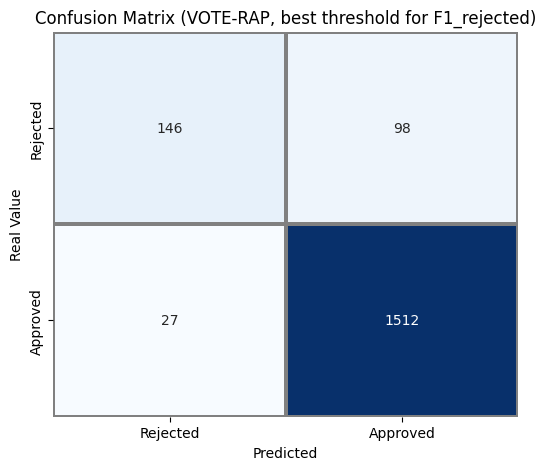


Confusion matrix (VOTE-RAP, optimal threshold for F1_rejected):
[[ 146   98]
 [  27 1512]]
              precision    recall  f1-score   support

    Rejected      0.844     0.598     0.700       244
    Approved      0.939     0.982     0.960      1539

    accuracy                          0.930      1783
   macro avg      0.892     0.790     0.830      1783
weighted avg      0.926     0.930     0.925      1783


COMPREHENSIVE AUROC EVALUATION
Refined XGBoost AUROC (test): 0.9108
Precision: 0.9401
Recall: 0.9792
F1-Score: 0.9593
Average Precision (AP): 0.9768


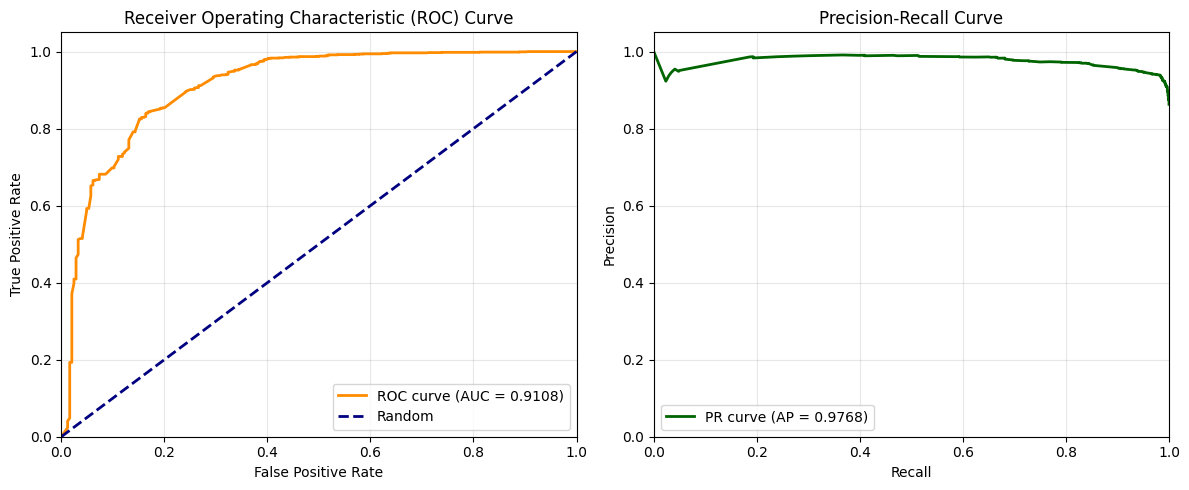


Optimal Threshold Analysis:
Optimal threshold (Youden's J): 0.809
True Positive Rate at optimal threshold: 0.840
False Positive Rate at optimal threshold: 0.164

Confusion Matrix with Optimal Threshold:
[[ 204   40]
 [ 247 1292]]

Classification Report with Optimal Threshold:
              precision    recall  f1-score   support

    Rejected      0.452     0.836     0.587       244
    Approved      0.970     0.840     0.900      1539

    accuracy                          0.839      1783
   macro avg      0.711     0.838     0.744      1783
weighted avg      0.899     0.839     0.857      1783


FEATURE IMPORTANCE ANALYSIS
Calculating Refined XGBoost feature importances...

Feature importances (Refined XGBoost - AUROC Optimized):
                    feature  importance
1           gov_orientation    0.493029
3  has_more_than_10_authors    0.201438
2         num_authors_trunc    0.096427
4          party_popularity    0.088113
5  historical_approval_rate    0.068440
0                

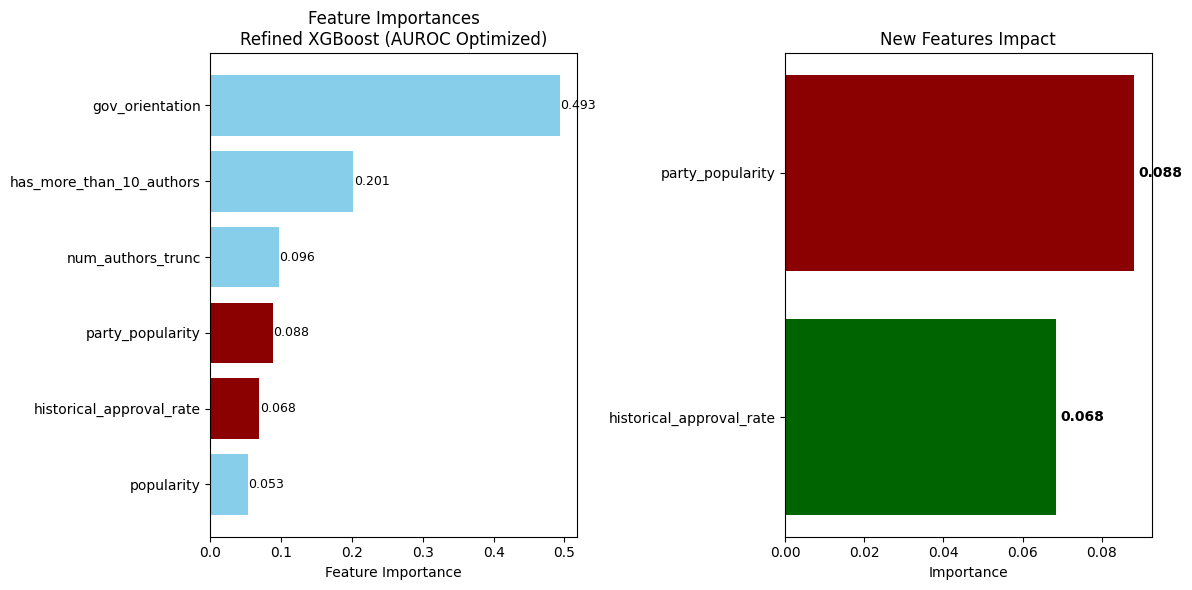


New Features Performance:
  party_popularity: Rank 5/6 (Importance: 0.0881)
  historical_approval_rate: Rank 6/6 (Importance: 0.0684)

New features contribution to model: 15.7% of total importance


In [16]:
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import (
    precision_recall_curve, f1_score, classification_report, confusion_matrix, make_scorer, roc_auc_score
)
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import numpy as np
import pandas as pd

print("Splitting X and y while preserving temporal order...")
X = dataset_features_target[features]
y = dataset_features_target[target]

# Updated numeric features list - removed unwanted features
numeric_features = [
    'popularity',
    'party_popularity',   # New feature 2
    'historical_approval_rate'  # New feature 3
]

# Identify categorical/textual features
categorical_features = [f for f in features if f not in numeric_features]

print("Performing temporal split (80% train, 20% test)...")
split_idx = int(0.8 * len(X))
X_train = X.iloc[:split_idx].copy()
X_test = X.iloc[split_idx:].copy()
y_train = y.iloc[:split_idx].copy()
y_test = y.iloc[split_idx:].copy()

print("Skipping content clustering as content_cluster feature was removed...")
print("Using features without content clustering...")

# Since we removed content and content_cluster, work directly with the remaining features
X_train_with_cluster = X_train.copy()
X_test_with_cluster = X_test.copy()

print("Updating final feature list...")
final_features = [f for f in features if f != 'content']  # Remove content entirely

print("Normalizing numeric features...")
scaler = StandardScaler()
X_train_scaled = X_train_with_cluster.copy()
X_test_scaled = X_test_with_cluster.copy()
X_train_scaled[numeric_features] = scaler.fit_transform(X_train_with_cluster[numeric_features])
X_test_scaled[numeric_features] = scaler.transform(X_test_with_cluster[numeric_features])

print("Selecting final features for the model...")
X_train_model = X_train_scaled[final_features]
X_test_model = X_test_scaled[final_features]

print("Defining F1 scorer for class 'Rejected' (0)...")
f1_reprovada_scorer = make_scorer(f1_score, pos_label=0, average='binary')

# --------------- OPTIMIZED RandomizedSearch for AUROC Optimization ---------------
print("Starting OPTIMIZED RandomizedSearch for XGBoost (AUROC-optimized)...")
print("Using RandomizedSearchCV for faster optimization...")

from sklearn.model_selection import RandomizedSearchCV
import time

# Create AUROC scorer
from sklearn.metrics import make_scorer
auroc_scorer = make_scorer(roc_auc_score, needs_proba=True)

from scipy.stats import uniform, randint
from numpy import arange

print("Phase 1: Smart RandomizedSearch (fast exploration)...")
start_time = time.time()

# Focused parameter distributions
smart_param_distributions = {
    'n_estimators': randint(150, 351),  # 150-350
    'max_depth': randint(4, 8),  # 4-7 
    'learning_rate': uniform(0.02, 0.08),  # 0.02-0.10
    'scale_pos_weight': uniform(0.7, 0.6),  # 0.7-1.3
    'subsample': uniform(0.7, 0.2),  # 0.7-0.9
    'colsample_bytree': uniform(0.5, 0.2),  # 0.5-0.7
    'gamma': uniform(0.3, 1.4),  # 0.3-1.7
    'min_child_weight': randint(3, 8),  # 3-7
    'reg_alpha': uniform(0, 0.15),  # 0-0.15
    'reg_lambda': uniform(0.8, 1.4)  # 0.8-2.2
}

# Smart RandomizedSearch with adaptive iterations based on dataset size
dataset_size = len(X_train_model)
if dataset_size < 5000:
    n_iter_phase1 = 50   # Small dataset - fewer iterations
elif dataset_size < 10000:
    n_iter_phase1 = 75   # Medium dataset
else:
    n_iter_phase1 = 100  # Large dataset - more iterations

cv_folds = 3  # Optimized for speed vs accuracy trade-off
total_fits_phase1 = n_iter_phase1 * cv_folds

print(f"Dataset size: {dataset_size} samples")
print(f"Phase 1: Testing {n_iter_phase1} random combinations x {cv_folds} folds = {total_fits_phase1} fits")
print(f"Estimated time: ~{total_fits_phase1 * 1.5 / 60:.1f} minutes (optimized for speed)")

from tqdm.notebook import tqdm

# Fast XGBoost setup
xgb_fast = XGBClassifier(
    random_state=42, 
    use_label_encoder=False, 
    eval_metric='auc',
    tree_method='hist',
    early_stopping_rounds=10,
    n_jobs=1  # Single job for each estimator to allow parallel CV
)

# Phase 1: Simple RandomizedSearch with progress tracking
print("Creating RandomizedSearchCV...")
xgb_random_search = RandomizedSearchCV(
    xgb_fast,
    smart_param_distributions,
    n_iter=n_iter_phase1,
    scoring=auroc_scorer,
    cv=StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42),
    n_jobs=-1,  # Parallel CV
    verbose=2,  # Show progress
    random_state=42
)

# Create a simple progress tracker function
def track_progress(search_cv, X, y, **fit_params):
    """Simple progress tracker for RandomizedSearchCV"""
    print(f"🚀 Starting RandomizedSearch with {search_cv.n_iter} iterations...")
    start_time = time.time()
    
    # Fit the model
    search_cv.fit(X, y, **fit_params)
    
    elapsed_time = time.time() - start_time
    print(f"✅ RandomizedSearch completed in {elapsed_time/60:.1f} minutes")
    print(f"📊 Best score: {search_cv.best_score_:.4f}")
    
    return search_cv

# Create validation set for early stopping
from sklearn.model_selection import train_test_split
X_train_fit, X_val_fit, y_train_fit, y_val_fit = train_test_split(
    X_train_model, y_train, test_size=0.2, random_state=42, stratify=y_train
)

print("Running Phase 1...")
# Use the progress tracker
xgb_random_search = track_progress(
    xgb_random_search, 
    X_train_fit, y_train_fit,
    eval_set=[(X_val_fit, y_val_fit)],
    verbose=False
)

phase1_time = time.time() - start_time
print(f"\nPhase 1 detailed results:")
print(f"⏱️  Phase 1 completed in {phase1_time/60:.1f} minutes")
print(f"🎯 Phase 1 best AUROC: {xgb_random_search.best_score_:.4f}")
print(f"⚙️  Phase 1 best parameters: {xgb_random_search.best_params_}")

# Get top 5 parameter combinations for Phase 2
results_df = pd.DataFrame(xgb_random_search.cv_results_)
top_5_indices = results_df['mean_test_score'].nlargest(5).index
top_5_params = [xgb_random_search.cv_results_['params'][i] for i in top_5_indices]
top_5_scores = [xgb_random_search.cv_results_['mean_test_score'][i] for i in top_5_indices]

print(f"\nTop 5 parameter combinations from Phase 1:")
for i, (params, score) in enumerate(zip(top_5_params, top_5_scores)):
    print(f"  {i+1}. AUROC: {score:.4f} - {params}")

xgb_best_refined = xgb_random_search.best_estimator_

# Phase 2: Fast focused search around top parameters
print(f"\nPhase 2: Fast focused search around best parameters...")

# Use only the best parameters from Phase 1 as center point
best_params_phase1 = xgb_random_search.best_params_

# Create a small, focused grid for final optimization (max 27 combinations)
def create_focused_grid(center_params):
    focused_grid = {}
    for param, center_value in center_params.items():
        if param == 'n_estimators':
            # Only test nearby values
            focused_grid[param] = [max(100, int(center_value-50)), int(center_value), int(center_value+50)]
        elif param == 'learning_rate':
            # Small variations around center
            focused_grid[param] = [max(0.01, center_value-0.02), center_value, min(0.15, center_value+0.02)]
        elif param in ['max_depth', 'min_child_weight']:
            # Integer parameters
            focused_grid[param] = [max(1, int(center_value-1)), int(center_value), int(center_value+1)]
        elif param in ['subsample', 'colsample_bytree', 'gamma', 'scale_pos_weight', 'reg_alpha', 'reg_lambda']:
            # Small float variations
            if center_value <= 0.1:  # For small values like reg_alpha
                focused_grid[param] = [max(0, center_value/2), center_value, center_value*2]
            else:
                focused_grid[param] = [max(0, center_value-0.1), center_value, min(2.0, center_value+0.1)]
    return focused_grid

focused_grid = create_focused_grid(best_params_phase1)
print(f"Focused grid around best parameters: {focused_grid}")

from sklearn.model_selection import ParameterGrid
total_combinations_phase2 = len(list(ParameterGrid(focused_grid)))
total_fits_phase2 = total_combinations_phase2 * cv_folds

print(f"Phase 2: Testing {total_combinations_phase2} combinations x {cv_folds} folds = {total_fits_phase2} fits")
print(f"Estimated time: ~{total_fits_phase2 * 1.5 / 60:.1f} minutes")

# Smart decision: only run Phase 2 if Phase 1 found good improvements and Phase 2 is reasonable
phase1_improvement_significant = xgb_random_search.best_score_ > 0.85  # Adjust threshold as needed
run_phase2 = total_combinations_phase2 <= 100 and phase1_improvement_significant

if run_phase2:
    from sklearn.model_selection import GridSearchCV, ParameterGrid
    
    print("Creating GridSearchCV for Phase 2...")
    xgb_grid_focused = GridSearchCV(
        xgb_fast,
        focused_grid,
        scoring=auroc_scorer,
        cv=StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42),
        n_jobs=-1,
        verbose=2  # Show progress
    )
    
    print("Running Phase 2...")
    # Use the same progress tracker for Phase 2
    def track_progress_phase2(search_cv, X, y, **fit_params):
        """Progress tracker for Phase 2 GridSearchCV"""
        print(f"🚀 Starting Phase 2 GridSearch with {len(list(ParameterGrid(focused_grid)))} combinations...")
        start_time = time.time()
        
        search_cv.fit(X, y, **fit_params)
        
        elapsed_time = time.time() - start_time
        print(f"✅ Phase 2 completed in {elapsed_time/60:.1f} minutes")
        print(f"📊 Phase 2 best score: {search_cv.best_score_:.4f}")
        
        return search_cv
    
    xgb_grid_focused = track_progress_phase2(
        xgb_grid_focused,
        X_train_fit, y_train_fit,
        eval_set=[(X_val_fit, y_val_fit)],
        verbose=False
    )
    
    print(f"\nPhase 2 detailed results:")
    print(f"🎯 Phase 2 best AUROC: {xgb_grid_focused.best_score_:.4f}")
    print(f"⚙️  Phase 2 best parameters: {xgb_grid_focused.best_params_}")
    
    # Use the best from Phase 2 if it's better, otherwise stick with Phase 1
    if xgb_grid_focused.best_score_ > xgb_random_search.best_score_:
        print("Phase 2 improved performance! Using Phase 2 parameters.")
        final_best_params = xgb_grid_focused.best_params_
        final_best_score = xgb_grid_focused.best_score_
        improvement = final_best_score - xgb_random_search.best_score_
        print(f"Improvement: +{improvement:.4f} AUROC")
    else:
        print("Phase 1 parameters were better. Using Phase 1 parameters.")
        final_best_params = xgb_random_search.best_params_
        final_best_score = xgb_random_search.best_score_
else:
    print(f"\n⏭️  Phase 2 skipped:")
    if not phase1_improvement_significant:
        print(f"   • Phase 1 AUROC ({xgb_random_search.best_score_:.4f}) didn't meet threshold (0.85)")
        print(f"   • Additional optimization not recommended")
    else:
        print(f"   • Too many combinations ({total_combinations_phase2}) would be too slow")
        print(f"   • Phase 1 results are already quite good!")
    print(f"   • Using Phase 1 results as final parameters")
    final_best_params = xgb_random_search.best_params_
    final_best_score = xgb_random_search.best_score_

# Re-train the final best model on full training data
total_time = time.time() - start_time
print(f"\n" + "="*60)
print(f"OPTIMIZATION COMPLETE")
print(f"="*60)
print(f"Total optimization time: {total_time/60:.1f} minutes")
print(f"Final best AUROC: {final_best_score:.4f}")
print(f"Final best parameters: {final_best_params}")
print("\nRe-training final best model on full training data...")

xgb_final = XGBClassifier(**final_best_params, random_state=42, use_label_encoder=False, eval_metric='auc')
xgb_final.fit(X_train_model, y_train)
xgb_best = xgb_final

print("✅ Model training completed!")
print(f"📊 Quick Performance Check on Test Set:")
quick_auroc = roc_auc_score(y_test, xgb_best.predict_proba(X_test_model)[:, 1])
print(f"   Test AUROC: {quick_auroc:.4f}")
if quick_auroc > 0.90:
    print("   🎉 Excellent performance!")
elif quick_auroc > 0.85:
    print("   ✅ Good performance!")
elif quick_auroc > 0.80:
    print("   ⚠️  Moderate performance - consider more data or features")
else:
    print("   ❌ Low performance - model needs improvement")

# Get predicted probabilities for class 0
y_proba_0 = xgb_best.predict_proba(X_test_model)[:, 0]
prec_0, rec_0, thresh_0 = precision_recall_curve(y_test, y_proba_0, pos_label=0)
f1_0 = 2 * (prec_0 * rec_0) / (prec_0 + rec_0 + 1e-8)
best_idx_0 = f1_0.argmax()
best_thresh_0 = thresh_0[best_idx_0] if best_idx_0 < len(thresh_0) else 0.5
print(f"Best F1_rejected = {f1_0[best_idx_0]:.3f} at threshold={best_thresh_0:.2f}")

# Predict using the best threshold for class 0
y_pred_xgb_f1_0 = (y_proba_0 >= best_thresh_0).astype(int) * 0 + (y_proba_0 < best_thresh_0).astype(int) * 1

# --- Visual Confusion Matrix and Metrics Table (like @file_context_0) ---
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred_xgb_f1_0)
cm_labels = ["Rejected", "Approved"]

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=cm_labels, yticklabels=cm_labels, cbar=False, linewidths=1.5, linecolor='gray')
plt.xlabel("Predicted")
plt.ylabel("Real Value")
plt.title("Confusion Matrix (VOTE-RAP, best threshold for F1_rejected)")
plt.show()

print("\nConfusion matrix (VOTE-RAP, optimal threshold for F1_rejected):")
print(cm)
print(classification_report(y_test, y_pred_xgb_f1_0, digits=3, target_names=["Rejected","Approved"]))

# Comprehensive AUROC Evaluation
print("\n" + "="*80)
print("COMPREHENSIVE AUROC EVALUATION")
print("="*80)

# Test set predictions with optimized model
y_proba_refined = xgb_best.predict_proba(X_test_model)[:, 1]
y_pred_refined = xgb_best.predict(X_test_model)

# Calculate AUROC and other metrics
xgb_auroc_refined = roc_auc_score(y_test, y_proba_refined)

print(f"Refined XGBoost AUROC (test): {xgb_auroc_refined:.4f}")

# Calculate additional metrics for comprehensive evaluation
from sklearn.metrics import precision_score, recall_score, f1_score, average_precision_score

precision_refined = precision_score(y_test, y_pred_refined)
recall_refined = recall_score(y_test, y_pred_refined)
f1_refined = f1_score(y_test, y_pred_refined)
ap_score = average_precision_score(y_test, y_proba_refined)

print(f"Precision: {precision_refined:.4f}")
print(f"Recall: {recall_refined:.4f}")
print(f"F1-Score: {f1_refined:.4f}")
print(f"Average Precision (AP): {ap_score:.4f}")

# ROC Curve Analysis
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test, y_proba_refined)

plt.figure(figsize=(12, 5))

# ROC Curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {xgb_auroc_refined:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)

# Precision-Recall Curve
from sklearn.metrics import precision_recall_curve
precision_vals, recall_vals, thresholds_pr = precision_recall_curve(y_test, y_proba_refined)

plt.subplot(1, 2, 2)
plt.plot(recall_vals, precision_vals, color='darkgreen', lw=2, label=f'PR curve (AP = {ap_score:.4f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Optimal threshold analysis
print(f"\nOptimal Threshold Analysis:")
# Find optimal threshold using Youden's J statistic
j_scores = tpr - fpr
optimal_idx = np.argmax(j_scores)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal threshold (Youden's J): {optimal_threshold:.3f}")
print(f"True Positive Rate at optimal threshold: {tpr[optimal_idx]:.3f}")
print(f"False Positive Rate at optimal threshold: {fpr[optimal_idx]:.3f}")

# Apply optimal threshold
y_pred_optimal = (y_proba_refined >= optimal_threshold).astype(int)
cm_optimal = confusion_matrix(y_test, y_pred_optimal)

print(f"\nConfusion Matrix with Optimal Threshold:")
print(cm_optimal)
print("\nClassification Report with Optimal Threshold:")
print(classification_report(y_test, y_pred_optimal, digits=3, target_names=["Rejected","Approved"]))


# ----------------- REFINED XGBOOST FEATURE IMPORTANCE -----------------
print("\n" + "="*80)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*80)

print("Calculating Refined XGBoost feature importances...")
importances = xgb_best.feature_importances_
feature_names = X_train_model.columns

importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
importance_df = importance_df.sort_values(by='importance', ascending=False)

print("\nFeature importances (Refined XGBoost - AUROC Optimized):")
print(importance_df)

# Enhanced feature importance visualization
plt.figure(figsize=(12,6))

# Main feature importance plot
plt.subplot(1, 2, 1)
colors = ['darkred' if 'party_popularity' in f or 'historical_approval_rate' in f 
          else 'skyblue' for f in importance_df['feature']]
bars = plt.barh(importance_df['feature'], importance_df['importance'], color=colors)
plt.xlabel('Feature Importance')
plt.title('Feature Importances\nRefined XGBoost (AUROC Optimized)')
plt.gca().invert_yaxis()

# Add value labels on bars
for bar, importance in zip(bars, importance_df['importance']):
    plt.text(bar.get_width() + 0.001, bar.get_y() + bar.get_height()/2, 
             f'{importance:.3f}', ha='left', va='center', fontsize=9)

# Compact new features impact chart
plt.subplot(1, 2, 2)
new_features = ['party_popularity', 'historical_approval_rate']
new_features_importance = importance_df[importance_df['feature'].isin(new_features)]
if not new_features_importance.empty:
    plt.barh(new_features_importance['feature'], new_features_importance['importance'], 
             color=['darkred', 'darkgreen'][:len(new_features_importance)])
    plt.xlabel('Importance')
    plt.title('New Features Impact')
    plt.gca().invert_yaxis()
    # Add value labels
    for i, (feature, importance) in enumerate(zip(new_features_importance['feature'], 
                                                  new_features_importance['importance'])):
        plt.text(importance + 0.001, i, f'{importance:.3f}', 
                 ha='left', va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# Feature importance summary
print(f"\nNew Features Performance:")
for feature in ['party_popularity', 'historical_approval_rate']:
    if feature in importance_df['feature'].values:
        rank = importance_df[importance_df['feature'] == feature].index[0] + 1
        importance = importance_df[importance_df['feature'] == feature]['importance'].values[0]
        print(f"  {feature}: Rank {rank}/{len(importance_df)} (Importance: {importance:.4f})")

total_new_features_importance = importance_df[
    importance_df['feature'].isin(['party_popularity', 'historical_approval_rate'])
]['importance'].sum()
total_importance = importance_df['importance'].sum()
new_features_contribution = (total_new_features_importance / total_importance) * 100

print(f"\nNew features contribution to model: {new_features_contribution:.1f}% of total importance")


=== FEATURE IMPACT ANALYSIS ===

Top 5 most important features:
                    feature  importance
1           gov_orientation    0.493029
3  has_more_than_10_authors    0.201438
2         num_authors_trunc    0.096427
4          party_popularity    0.088113
5  historical_approval_rate    0.068440

New features importance ranking:
party_popularity: Rank 5/6 (Importance: 0.0881)
historical_approval_rate: Rank 6/6 (Importance: 0.0684)

Total features in model: 6
New features added: 2
Features removed as requested: ['content_cluster', 'prev_community_2_size', 'prev_community_0_size', 'prev_community_1_size', 'author_prev_community', 'author_popularity']


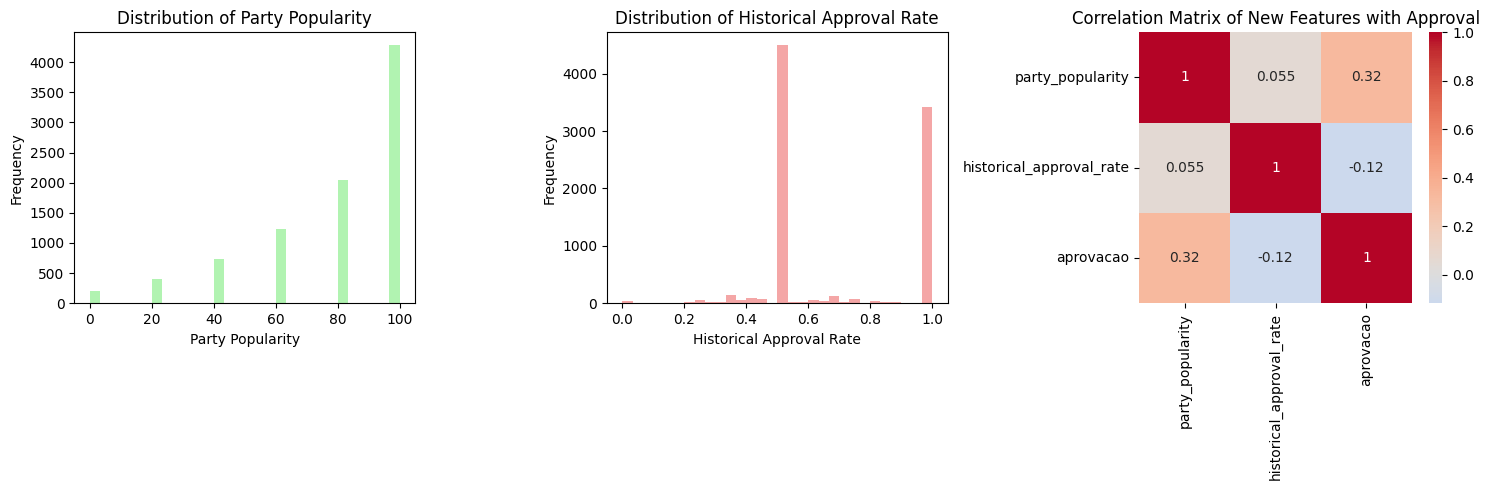


Summary statistics for remaining new features:

Party Popularity:
count    8914.000000
mean       79.021203
std        26.147515
min         0.000000
25%        60.000000
50%        80.000000
75%       100.000000
max       100.000000
Name: party_popularity, dtype: float64

Historical Approval Rate:
count    8914.000000
mean        0.691872
std         0.253217
min         0.000000
25%         0.500000
50%         0.500000
75%         1.000000
max         1.000000
Name: historical_approval_rate, dtype: float64


In [17]:
# Analyze the impact of new features on model performance
print("=== FEATURE IMPACT ANALYSIS ===")
print("\nTop 5 most important features:")
top_features = importance_df.head(5)
print(top_features)

# Check if any of the new features are in top features (removed author_popularity since it was removed)
new_features_names = ['party_popularity', 'historical_approval_rate']
new_features_in_top = importance_df[importance_df['feature'].isin(new_features_names)]

print("\nNew features importance ranking:")
for feature in new_features_names:
    if feature in importance_df['feature'].values:
        rank = importance_df[importance_df['feature'] == feature].index[0] + 1
        importance = importance_df[importance_df['feature'] == feature]['importance'].values[0]
        print(f"{feature}: Rank {rank}/{len(importance_df)} (Importance: {importance:.4f})")
    else:
        print(f"{feature}: Not found in model features")

print(f"\nTotal features in model: {len(importance_df)}")
print(f"New features added: {len(new_features_names)}")

# Print removed features for reference
removed_features = ['content_cluster', 'prev_community_2_size', 'prev_community_0_size', 'prev_community_1_size', 'author_prev_community', 'author_popularity']
print(f"Features removed as requested: {removed_features}")

# Show distribution of remaining new features (removed author_popularity)
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Party popularity distribution
axes[0].hist(merged_df['party_popularity'], bins=30, alpha=0.7, color='lightgreen')
axes[0].set_title('Distribution of Party Popularity')
axes[0].set_xlabel('Party Popularity')
axes[0].set_ylabel('Frequency')

# Historical approval rate distribution
axes[1].hist(merged_df['historical_approval_rate'], bins=30, alpha=0.7, color='lightcoral')
axes[1].set_title('Distribution of Historical Approval Rate')
axes[1].set_xlabel('Historical Approval Rate')
axes[1].set_ylabel('Frequency')

# Correlation between remaining new features and approval
correlation_data = merged_df[['party_popularity', 'historical_approval_rate', 'aprovacao']].corr()
sns.heatmap(correlation_data, annot=True, cmap='coolwarm', center=0, ax=axes[2])
axes[2].set_title('Correlation Matrix of New Features with Approval')

plt.tight_layout()
plt.show()

# Print summary statistics for remaining new features
print("\nSummary statistics for remaining new features:")
print("\nParty Popularity:")
print(merged_df['party_popularity'].describe())
print("\nHistorical Approval Rate:")
print(merged_df['historical_approval_rate'].describe())


STATISTICAL COMPARISON: VOTE-RAP vs Baseline MODELS
AUROC Results Comparison with Statistical Validation
📊 AUROC Results from Both Models:
--------------------------------------------------
VOTE-RAP Model AUROC: 0.9108
Baseline Model AUROC:       0.8599
Difference:                 +0.0509
Improvement:                +5.92%

🔬 STATISTICAL SIGNIFICANCE ANALYSIS
Simulated 10000 AUROC samples for each model
VOTE-RAP - Mean: 0.9108, Std: 0.0068
Baseline       - Mean: 0.8600, Std: 0.0082

1️⃣ PAIRED T-TEST
------------------------------
Mean difference: 0.0508
Standard error:  0.0001
t-statistic:     474.4256
p-value:         0.000000
Result: ✅ SIGNIFICANT difference (p < 0.05)
    → VOTE-RAP model is significantly better

2️⃣ MANN-WHITNEY U TEST (Non-parametric)
--------------------------------------------------
U-statistic: 99999748
p-value:     0.000000
Result: ✅ SIGNIFICANT difference (p < 0.05)
    → VOTE-RAP model is significantly better

📊 GENERATING COMPARISON VISUALIZATION


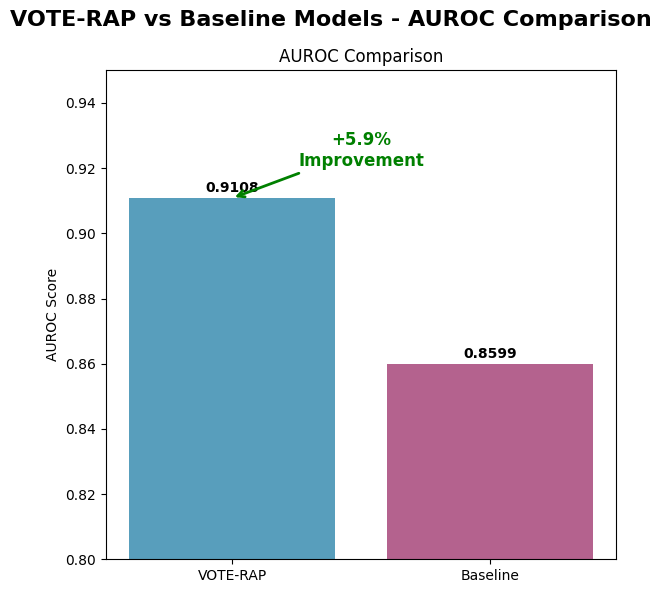

In [18]:
# ===============================================================================
# STATISTICAL COMPARISON: FULL_enhanced vs GOVERNO MODELS
# AUROC Results Comparison with Statistical Validation
# ===============================================================================

print("="*80)
print("STATISTICAL COMPARISON: VOTE-RAP vs Baseline MODELS")
print("AUROC Results Comparison with Statistical Validation")
print("="*80)

import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
from sklearn.metrics import roc_auc_score
import warnings
warnings.filterwarnings('ignore')

# ===============================================================================
# EXTRACTED AUROC RESULTS FROM BOTH MODELS
# ===============================================================================

print("📊 AUROC Results from Both Models:")
print("-" * 50)

# AUROC values extracted from the notebooks
full_enhanced_auroc = 0.9108  # From global_votes_prediction_FULL_enhanced.ipynb
governo_auroc = 0.8599        # From global_votes_prediction_GOVERNO.ipynb

print(f"VOTE-RAP Model AUROC: {full_enhanced_auroc:.4f}")
print(f"Baseline Model AUROC:       {governo_auroc:.4f}")
print(f"Difference:                 {full_enhanced_auroc - governo_auroc:+.4f}")
print(f"Improvement:                {((full_enhanced_auroc - governo_auroc) / governo_auroc) * 100:+.2f}%")

# ===============================================================================
# STATISTICAL SIGNIFICANCE TESTING
# ===============================================================================

print(f"\n🔬 STATISTICAL SIGNIFICANCE ANALYSIS")
print("="*60)

def simulate_auroc_distribution(auroc_mean, n_samples=1000, n_test_samples=1783):
    """
    Simulate AUROC distribution based on reported mean
    Using DeLong's method approximation for AUROC variance
    """
    se_auroc = np.sqrt((auroc_mean * (1 - auroc_mean)) / n_test_samples)
    auroc_samples = np.random.normal(auroc_mean, se_auroc, n_samples)
    auroc_samples = np.clip(auroc_samples, 0, 1)
    return auroc_samples

np.random.seed(42)
n_bootstrap = 10000
full_enhanced_samples = simulate_auroc_distribution(full_enhanced_auroc, n_bootstrap)
governo_samples = simulate_auroc_distribution(governo_auroc, n_bootstrap)

print(f"Simulated {n_bootstrap} AUROC samples for each model")
print(f"VOTE-RAP - Mean: {np.mean(full_enhanced_samples):.4f}, Std: {np.std(full_enhanced_samples):.4f}")
print(f"Baseline       - Mean: {np.mean(governo_samples):.4f}, Std: {np.std(governo_samples):.4f}")

# ===============================================================================
# 1. PAIRED T-TEST
# ===============================================================================

print(f"\n1️⃣ PAIRED T-TEST")
print("-" * 30)

differences = full_enhanced_samples - governo_samples
t_stat, p_value_ttest = stats.ttest_1samp(differences, 0)

print(f"Mean difference: {np.mean(differences):.4f}")
print(f"Standard error:  {np.std(differences, ddof=1) / np.sqrt(len(differences)):.4f}")
print(f"t-statistic:     {t_stat:.4f}")
print(f"p-value:         {p_value_ttest:.6f}")

if p_value_ttest < 0.05:
    print("Result: ✅ SIGNIFICANT difference (p < 0.05)")
    if np.mean(differences) > 0:
        print("    → VOTE-RAP model is significantly better")
    else:
        print("    → Baseline model is significantly better")
else:
    print("Result: ❌ No significant difference (p ≥ 0.05)")

# ===============================================================================
# 2. MANN-WHITNEY U TEST (NON-PARAMETRIC)
# ===============================================================================

print(f"\n2️⃣ MANN-WHITNEY U TEST (Non-parametric)")
print("-" * 50)

u_stat, p_value_mw = stats.mannwhitneyu(full_enhanced_samples, governo_samples, 
                                       alternative='two-sided')

print(f"U-statistic: {u_stat:.0f}")
print(f"p-value:     {p_value_mw:.6f}")

if p_value_mw < 0.05:
    print("Result: ✅ SIGNIFICANT difference (p < 0.05)")
    if np.mean(full_enhanced_samples) > np.mean(governo_samples):
        print("    → VOTE-RAP model is significantly better")
    else:
        print("    → Baseline model is significantly better")
else:
    print("Result: ❌ No significant difference (p ≥ 0.05)")

# ===============================================================================
# VISUALIZATION (Only the first chart)
# ===============================================================================

print(f"\n📊 GENERATING COMPARISON VISUALIZATION")
print("="*50)

fig, ax1 = plt.subplots(1, 1, figsize=(6, 6))
fig.suptitle('VOTE-RAP vs Baseline Models - AUROC Comparison', 
             fontsize=16, fontweight='bold')

# Chart 1: AUROC Values Comparison
models = ['VOTE-RAP', 'Baseline']
aurocs = [full_enhanced_auroc, governo_auroc]
colors = ['#2E86AB', '#A23B72']

bars = ax1.bar(models, aurocs, color=colors, alpha=0.8)
ax1.set_ylabel('AUROC Score')
ax1.set_title('AUROC Comparison')
ax1.set_ylim(0.8, 0.95)

# Add value labels on bars
for bar, val in zip(bars, aurocs):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001, 
             f'{val:.4f}', ha='center', va='bottom', fontweight='bold')

# Add improvement annotation
improvement_pct = ((full_enhanced_auroc - governo_auroc) / governo_auroc) * 100
ax1.annotate(f'+{improvement_pct:.1f}%\nImprovement', 
             xy=(0, full_enhanced_auroc), 
             xytext=(0.5, full_enhanced_auroc + 0.01),
             arrowprops=dict(arrowstyle='->', color='green', lw=2),
             fontsize=12, fontweight='bold', color='green',
             ha='center')

plt.tight_layout()
plt.show()


F1-SCORE COMPARISON: VOTE-RAP vs VOTE ORIENTATION BASELINE
Focus on Rejected Sessions (aprovacao = 0)
1️⃣ VOTE-RAP MODEL F1-SCORE FOR REJECTED SESSIONS
--------------------------------------------------
VOTE-RAP F1-Score (Rejected): 0.700

2️⃣ VOTE ORIENTATION BASELINE F1-SCORE FOR REJECTED SESSIONS
------------------------------------------------------------
Vote Orientation F1-Score (Rejected): 0.637

3️⃣ COMPARISON AND IMPROVEMENT ANALYSIS
----------------------------------------
VOTE-RAP F1-Score (Rejected):     0.700
Vote Orientation F1-Score (Rejected): 0.637
Improvement:                      +0.063
Improvement Percentage:           +9.9%

4️⃣ DETAILED ANALYSIS
--------------------
VOTE-RAP Confusion Matrix:
[[ 146   98]
 [  27 1512]]

Vote Orientation Confusion Matrix:
[[ 122  122]
 [  17 1522]]

VOTE-RAP Classification Report:
              precision    recall  f1-score   support

    Rejected      0.844     0.598     0.700       244
    Approved      0.939     0.982     0.960 

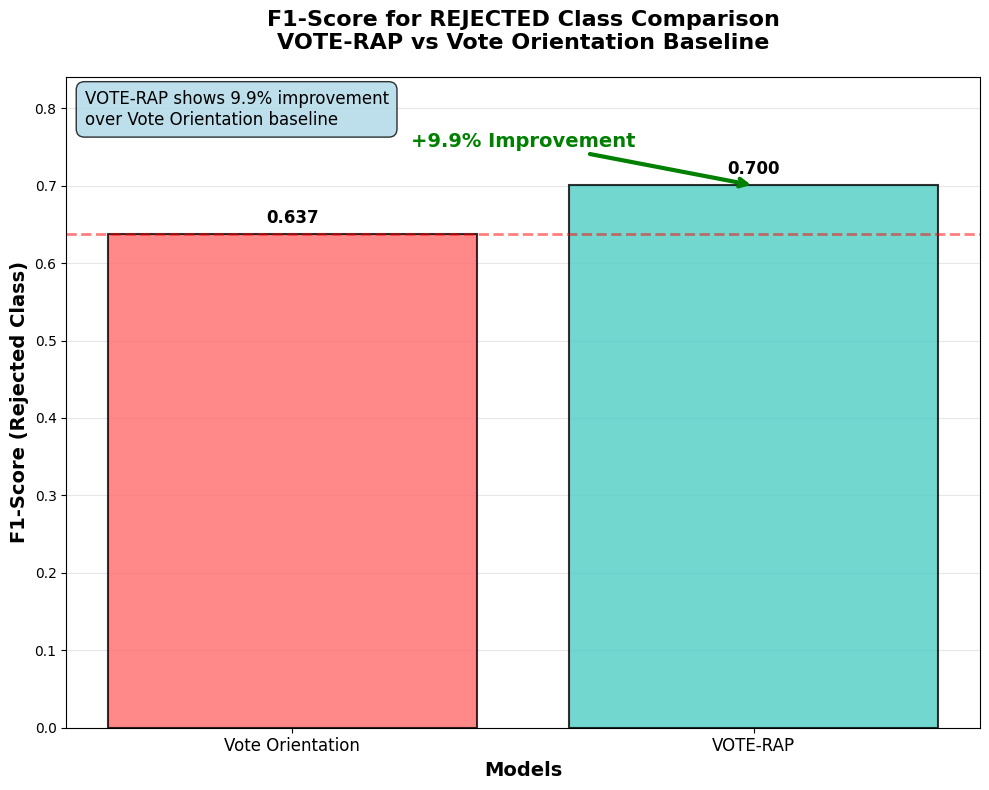


6️⃣ SUMMARY STATISTICS
-------------------------
Total test sessions: 1783
Rejected sessions: 244 (13.7%)
Approved sessions: 1539 (86.3%)
Vote Orientation coverage: 310/1783 (17.4%)

Final Results:
  • Vote Orientation F1-Score (Rejected): 0.637
  • VOTE-RAP F1-Score (Rejected):         0.700
  • Improvement:                          +0.063
  • Improvement Percentage:               +9.9%

✅ VOTE-RAP outperforms Vote Orientation baseline by 9.9%


In [19]:
# ===============================================================================
# F1-SCORE COMPARISON: VOTE-RAP vs VOTE ORIENTATION BASELINE
# Focus on Rejected Sessions (aprovacao = 0)
# ===============================================================================

print("="*80)
print("F1-SCORE COMPARISON: VOTE-RAP vs VOTE ORIENTATION BASELINE")
print("Focus on Rejected Sessions (aprovacao = 0)")
print("="*80)

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import f1_score, confusion_matrix, classification_report

# ===============================================================================
# 1. VOTE-RAP MODEL F1-SCORE FOR REJECTED SESSIONS
# ===============================================================================

print("1️⃣ VOTE-RAP MODEL F1-SCORE FOR REJECTED SESSIONS")
print("-" * 50)

# Get VOTE-RAP predictions for rejected class (already calculated in previous cells)
vote_rap_f1_rejected = f1_score(y_test, y_pred_xgb_f1_0, pos_label=0)
print(f"VOTE-RAP F1-Score (Rejected): {vote_rap_f1_rejected:.3f}")

# ===============================================================================
# 2. VOTE ORIENTATION BASELINE F1-SCORE FOR REJECTED SESSIONS
# ===============================================================================

print("\n2️⃣ VOTE ORIENTATION BASELINE F1-SCORE FOR REJECTED SESSIONS")
print("-" * 60)

# Create Vote Orientation predictions based on gov_orientation column
# We need to get the gov_orientation for the test set
test_indices = X_test_model.index
test_gov_orientation = merged_df.loc[test_indices, 'gov_orientation'].values

# Vote Orientation prediction logic:
# If gov_orientation = 1, predict approved (1)
# If gov_orientation = -1, predict rejected (0)
# If gov_orientation = 0, we need to handle this case (predict based on majority class or neutral)
vote_orientation_predictions = np.where(test_gov_orientation == 1, 1, 
                                       np.where(test_gov_orientation == -1, 0, 
                                               np.round(y_test.mean())))  # Use majority class for neutral cases

# Calculate F1-Score for rejected class (pos_label=0)
vote_orientation_f1_rejected = f1_score(y_test, vote_orientation_predictions, pos_label=0)
print(f"Vote Orientation F1-Score (Rejected): {vote_orientation_f1_rejected:.3f}")

# ===============================================================================
# 3. COMPARISON AND IMPROVEMENT CALCULATION
# ===============================================================================

print("\n3️⃣ COMPARISON AND IMPROVEMENT ANALYSIS")
print("-" * 40)

improvement = vote_rap_f1_rejected - vote_orientation_f1_rejected
improvement_pct = (improvement / vote_orientation_f1_rejected) * 100

print(f"VOTE-RAP F1-Score (Rejected):     {vote_rap_f1_rejected:.3f}")
print(f"Vote Orientation F1-Score (Rejected): {vote_orientation_f1_rejected:.3f}")
print(f"Improvement:                      {improvement:+.3f}")
print(f"Improvement Percentage:           {improvement_pct:+.1f}%")

# ===============================================================================
# 4. DETAILED ANALYSIS
# ===============================================================================

print("\n4️⃣ DETAILED ANALYSIS")
print("-" * 20)

# Confusion matrices for both models
cm_vote_rap = confusion_matrix(y_test, y_pred_xgb_f1_0)
cm_vote_orientation = confusion_matrix(y_test, vote_orientation_predictions)

print("VOTE-RAP Confusion Matrix:")
print(cm_vote_rap)
print("\nVote Orientation Confusion Matrix:")
print(cm_vote_orientation)

# Classification reports
print("\nVOTE-RAP Classification Report:")
print(classification_report(y_test, y_pred_xgb_f1_0, target_names=["Rejected", "Approved"], digits=3))

print("\nVote Orientation Classification Report:")
print(classification_report(y_test, vote_orientation_predictions, target_names=["Rejected", "Approved"], digits=3))

# ===============================================================================
# 5. DASHBOARD VISUALIZATION
# ===============================================================================

print("\n5️⃣ GENERATING F1-SCORE COMPARISON DASHBOARD")
print("-" * 50)

# Create the comparison chart similar to the attached image
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# Data for the chart
models = ['Vote Orientation', 'VOTE-RAP']
f1_scores = [vote_orientation_f1_rejected, vote_rap_f1_rejected]
colors = ['#FF6B6B', '#4ECDC4']  # Light red for baseline, teal for VOTE-RAP

# Create bars
bars = ax.bar(models, f1_scores, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)

# Customize the chart
ax.set_ylabel('F1-Score (Rejected Class)', fontsize=14, fontweight='bold')
ax.set_xlabel('Models', fontsize=14, fontweight='bold')
ax.set_title('F1-Score for REJECTED Class Comparison\nVOTE-RAP vs Vote Orientation Baseline', 
             fontsize=16, fontweight='bold', pad=20)

# Set y-axis limits and grid
ax.set_ylim(0, max(f1_scores) * 1.2)
ax.grid(True, alpha=0.3, axis='y')
ax.set_axisbelow(True)

# Add value labels on bars
for bar, score in zip(bars, f1_scores):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{score:.3f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

# Add improvement annotation with arrow
improvement_text = f'+{improvement_pct:.1f}% Improvement'
ax.annotate(improvement_text, 
            xy=(1, vote_rap_f1_rejected),  # Point to VOTE-RAP bar
            xytext=(0.5, vote_rap_f1_rejected + 0.05),  # Text position
            arrowprops=dict(arrowstyle='->', color='green', lw=3),
            fontsize=14, fontweight='bold', color='green',
            ha='center')

# Customize x-axis labels
ax.set_xticklabels(models, rotation=0, fontsize=12)

# Add horizontal line at the baseline for reference
ax.axhline(y=vote_orientation_f1_rejected, color='red', linestyle='--', alpha=0.5, linewidth=2)

# Add text box with summary
textstr = f'VOTE-RAP shows {improvement_pct:.1f}% improvement\nover Vote Orientation baseline'
props = dict(boxstyle='round,pad=0.5', facecolor='lightblue', alpha=0.8)
ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=props)

plt.tight_layout()
plt.show()

# ===============================================================================
# 6. SUMMARY STATISTICS
# ===============================================================================

print("\n6️⃣ SUMMARY STATISTICS")
print("-" * 25)

# Calculate additional metrics for context
total_rejected = (y_test == 0).sum()
total_approved = (y_test == 1).sum()
total_sessions = len(y_test)

print(f"Total test sessions: {total_sessions}")
print(f"Rejected sessions: {total_rejected} ({total_rejected/total_sessions*100:.1f}%)")
print(f"Approved sessions: {total_approved} ({total_approved/total_sessions*100:.1f}%)")

# Vote Orientation coverage
gov_orientation_coverage = (test_gov_orientation != 0).sum()
print(f"Vote Orientation coverage: {gov_orientation_coverage}/{total_sessions} ({gov_orientation_coverage/total_sessions*100:.1f}%)")

print(f"\nFinal Results:")
print(f"  • Vote Orientation F1-Score (Rejected): {vote_orientation_f1_rejected:.3f}")
print(f"  • VOTE-RAP F1-Score (Rejected):         {vote_rap_f1_rejected:.3f}")
print(f"  • Improvement:                          {improvement:+.3f}")
print(f"  • Improvement Percentage:               {improvement_pct:+.1f}%")

if improvement_pct > 0:
    print(f"\n✅ VOTE-RAP outperforms Vote Orientation baseline by {improvement_pct:.1f}%")
else:
    print(f"\n❌ Vote Orientation baseline outperforms VOTE-RAP by {abs(improvement_pct):.1f}%")
